문제 정의 : 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의 <br>
사망 :0, 생존 :1

라이브러리 임포트

In [1]:
# Libraries for reading and handling the data

import numpy as np
import pandas as pd
import re   # 정규식 

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Libraries for Analysing the ML model
from sklearn import metrics



데이터 준비하기

In [2]:
train_path ='train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic=pd.read_csv(train_path, index_col=index, dtype=dtypes)



In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


데이터 시각화

In [5]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

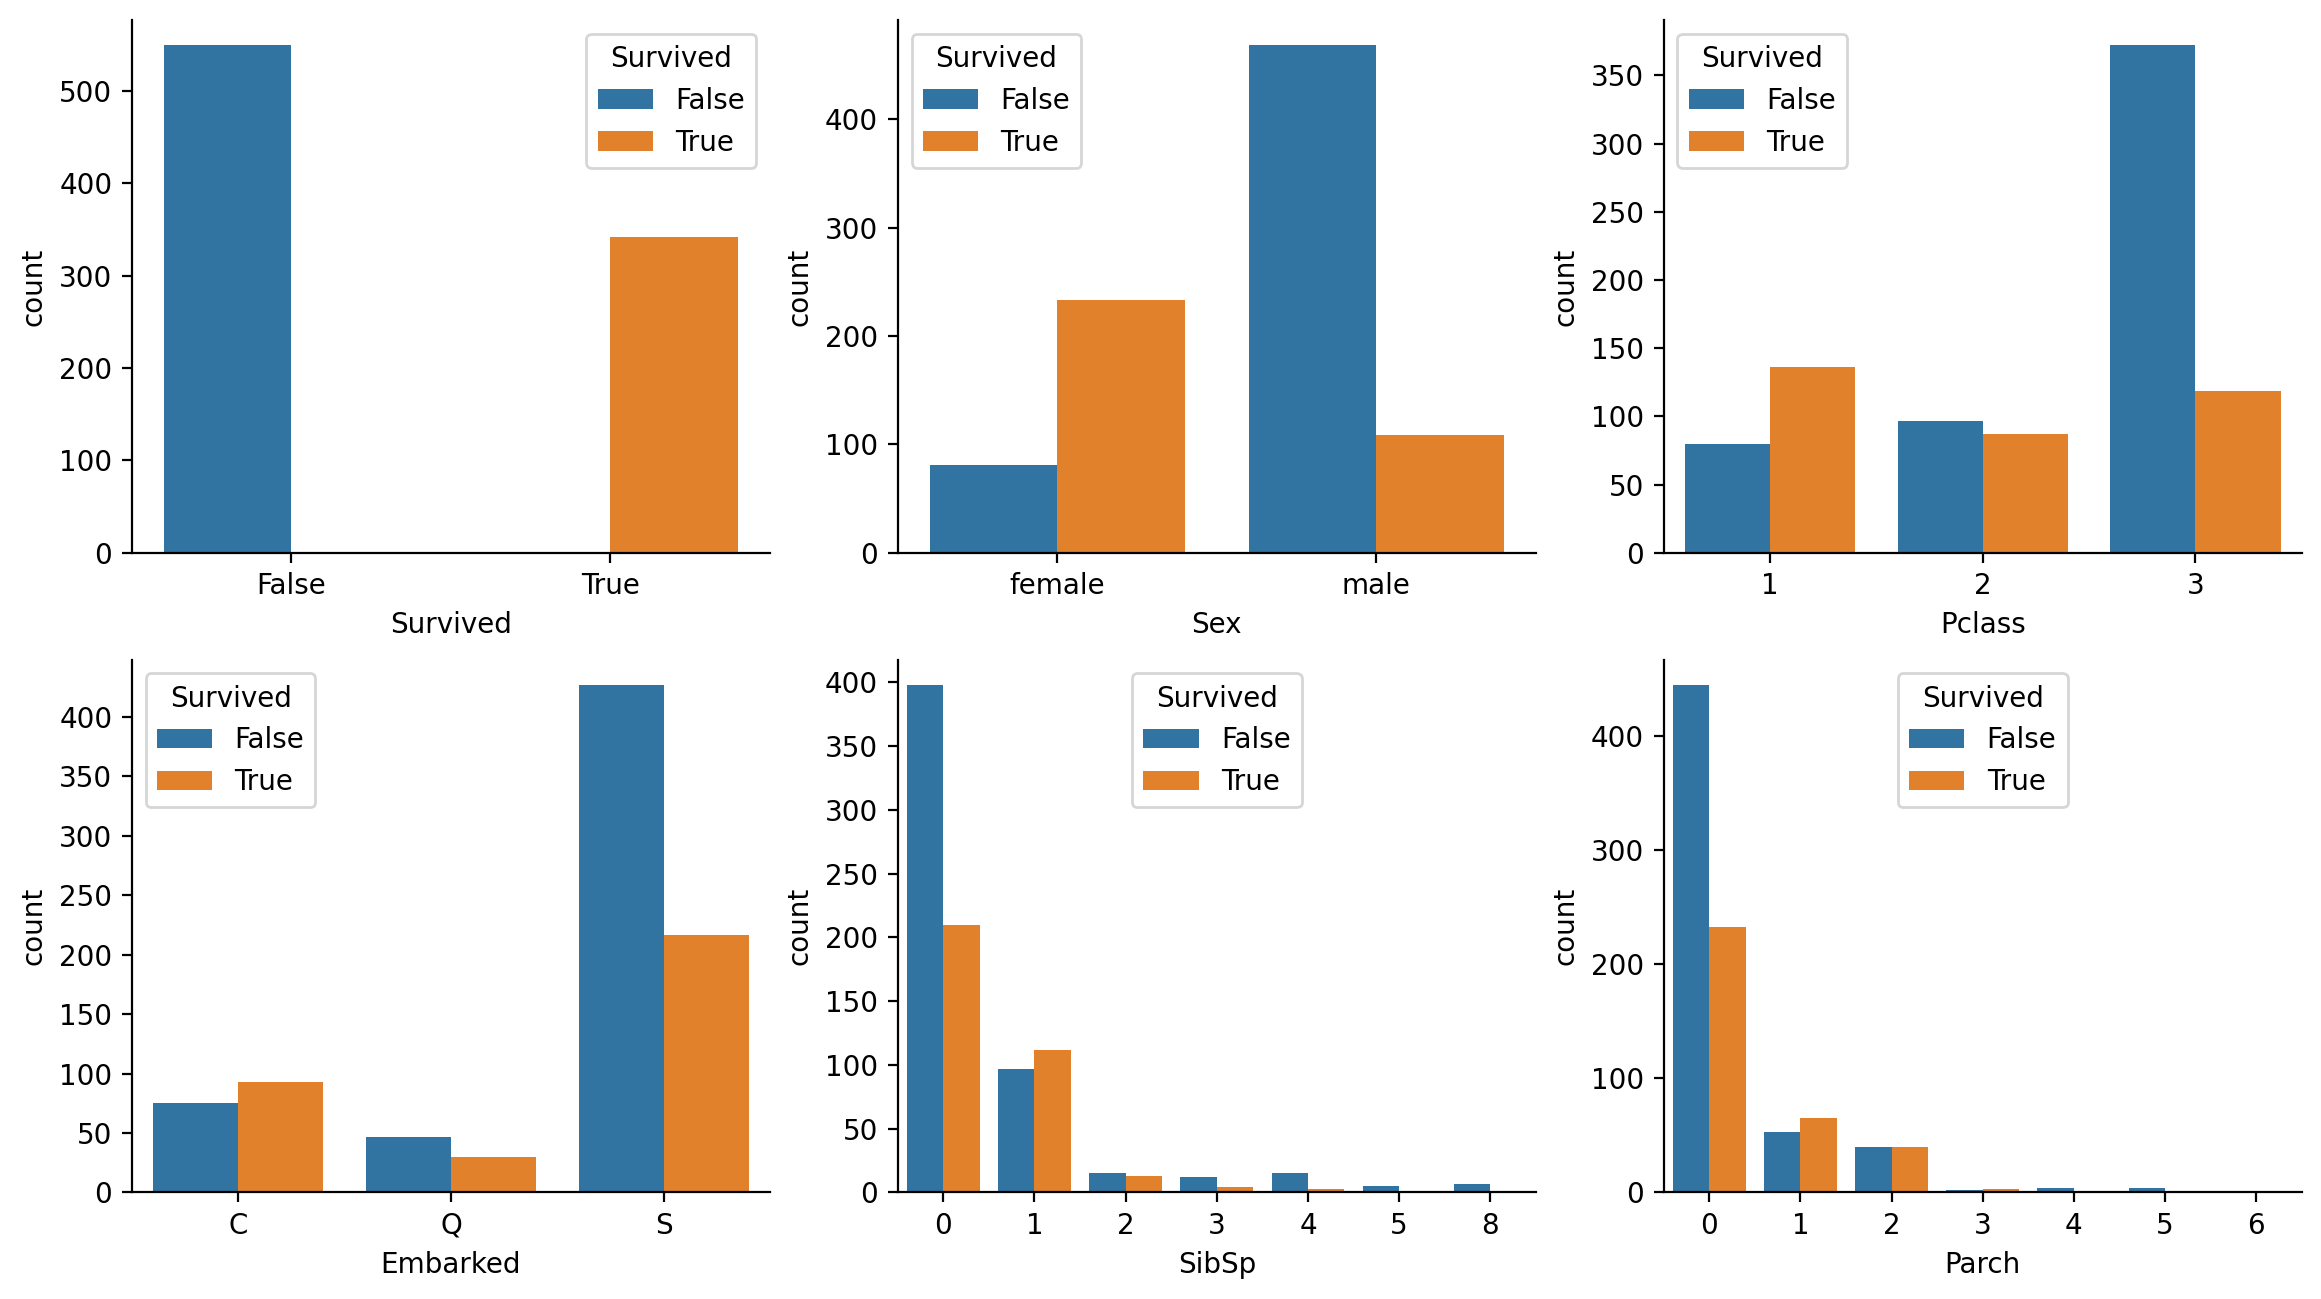

In [6]:
attributes=['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(14,12), dpi=200)

for i, feature in enumerate(attributes) :
  plt.subplot(3,3,i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

sns.despine()

데이터 전처리

In [7]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [8]:
def get_title(name) :
  return re.split(',|\.', name)[1].strip()
  # 정규식-> ,뒤에 있는 것을 잘라내

In [9]:
titanic['Name'].apply(get_title)

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object

In [10]:
titanic.head()
#사람의 이름에서 타이틀을 빼줬어?

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# 이름에서 호칭 추출(Miss, Mrs, Mr)
titanic['title']=titanic['Name'].apply(get_title)

In [12]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계 함수 -> 카운트, 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [13]:
# Survived 컬럼 레이어 정리
titles.columns= titles.columns.droplevel()

In [14]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [15]:
# 호칭 추출이 되지 않은 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title']=titanic['title'].replace(uncommon_titles, 'other')

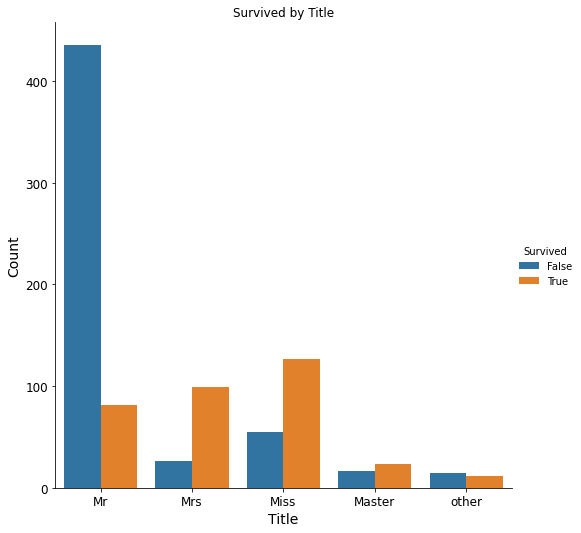

In [16]:
sns.catplot(x='title', kind='count', hue='Survived',
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Title', fontsize=14)
plt.title('Survived by Title')
plt.show()

In [17]:
# 가족 사이즈(fam_size)-> SibSp(동승한 자매 또는 배우자) + Parch(동승한 부모 또는 자식수)
titanic['fam_size']=titanic['SibSp'] + titanic['Parch']


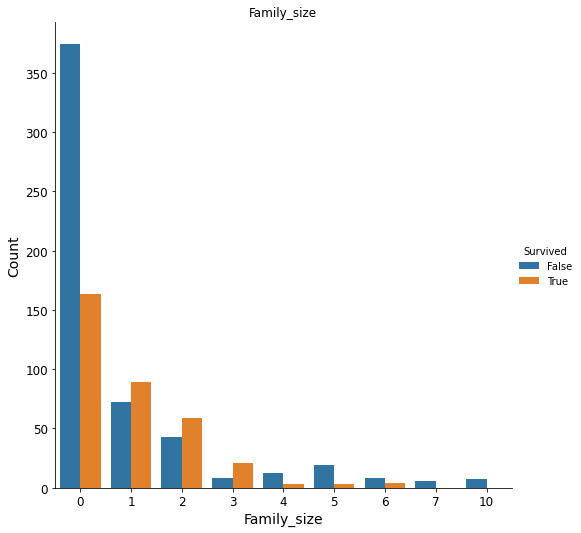

In [18]:
sns.catplot(x='fam_size', kind='count', hue='Survived',
            data=titanic, height=7)
plt.tick_params(labelsize=12)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Family_size', fontsize=14)
plt.title('Family_size')
plt.show()

In [19]:
# 텍스트 데이터 삭제하기
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'Embarked','title'], axis=1)

In [20]:
# 여성을 1로 남성을 0으로 처리
tmp=[]
for each in titanic['Sex'] :
  if each == 'female' :
    tmp.append(1)
  elif each == 'male' :
    tmp.append(0)
  else :
    tmp.append(np.nan)

titanic['Sex'] = tmp

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


데이터 형변환 및 결손 데이터 처리

In [22]:
# 데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


데이터 분리하기 X 문제집, y 정답

In [23]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)


훈련 데이터, 테스트 데이터셋 분리하기

In [24]:
X_train, X_test, y_train, y_test = train_test_split(titanic,
                                                    titanic_labels ,
                                                    train_size=0.8)

머신러닝 모델 구축 -1) LogisticRegression


In [25]:
log_reg = LogisticRegression().fit(X_train, y_train)

# 정확도 확인
print('Train data Score: ', log_reg.score(X_train, y_train))
print('Test data Score: ', log_reg.score(X_test, y_test))

Train data Score:  0.7985989492119089
Test data Score:  0.8251748251748252


머신러닝 모델 구축 -2) Decision Tree

In [26]:
tree= DecisionTreeClassifier(max_depth=5,
                             min_samples_leaf=20,
                             min_samples_split=40).fit(X_train, y_train)

In [27]:
#정확도 확인
print('Train data Score: ', log_reg.score(X_train, y_train))
print('Test data Score: ', log_reg.score(X_test, y_test))


Train data Score:  0.7985989492119089
Test data Score:  0.8251748251748252


머신러닝 모델 구축 03. GradientBoostingClassifier

In [28]:
boost=GradientBoostingClassifier(max_depth=3,
                                 learning_rate=0.05).fit(X_train, y_train)
                                 

In [29]:
#정확도 확인
print('Train data Score: ', boost.score(X_train, y_train))
print('Test data Score: ', boost.score(X_test, y_test))


Train data Score:  0.8756567425569177
Test data Score:  0.7902097902097902


머신러닝 모델구축 04.RandomForestClassifier

In [30]:
random=RandomForestClassifier(n_estimators=300,
                                 random_state=0).fit(X_train, y_train)

In [31]:
#정확도 확인
print('Train data Score: ', random.score(X_train, y_train))
print('Test data Score: ', random.score(X_test, y_test))

Train data Score:  0.9877408056042032
Test data Score:  0.8111888111888111


In [32]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

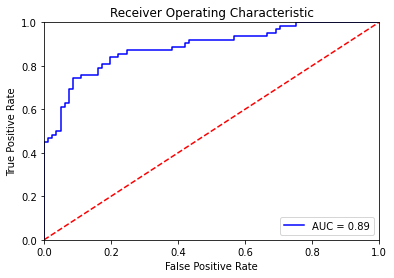

In [33]:
# Logistic Regression ROC
plot_auc_roc(log_reg)

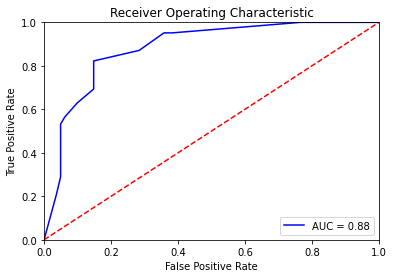

In [34]:
# Logistic Decision Tree
plot_auc_roc(tree)

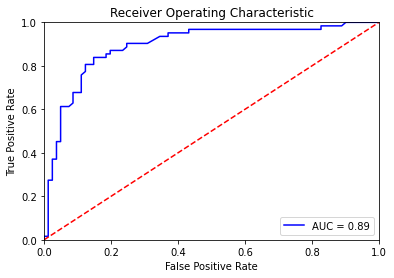

In [35]:
# GradientBoostingClassifier
plot_auc_roc(boost)

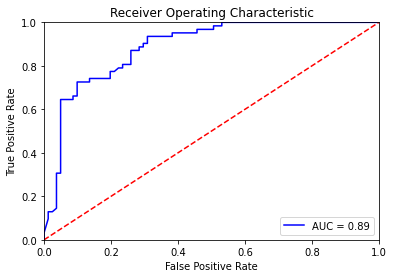

In [36]:
# Random
plot_auc_roc(random)

모델 성능 평가

In [37]:
# Logistic Regression 평가
lg_y_hat = log_reg.predict(X_test)
lg_report=metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가지표')
print(lg_report)

print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )


Logistic Regression 평가지표
              precision    recall  f1-score   support

       False       0.80      0.91      0.86        81
        True       0.86      0.71      0.78        62

    accuracy                           0.83       143
   macro avg       0.83      0.81      0.82       143
weighted avg       0.83      0.83      0.82       143

accuracy 0.8251748251748252
precision 0.8627450980392157
recall 0.7096774193548387
f1 0.7787610619469026


In [38]:
# Tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report=metrics.classification_report(y_test, tree_y_hat)
print('Tree 평가지표')
print(tree_report)

print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

Tree 평가지표
              precision    recall  f1-score   support

       False       0.77      0.88      0.82        81
        True       0.80      0.66      0.73        62

    accuracy                           0.78       143
   macro avg       0.79      0.77      0.77       143
weighted avg       0.79      0.78      0.78       143

accuracy 0.7832167832167832
precision 0.803921568627451
recall 0.6612903225806451
f1 0.7256637168141592


In [39]:
# GradientBoostingClassifier 평가지표

boost_y_hat = boost.predict(X_test)
boost_report=metrics.classification_report(y_test, boost_y_hat)
print('boost 평가지표')
print(boost_report)

print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )


boost 평가지표
              precision    recall  f1-score   support

       False       0.76      0.91      0.83        81
        True       0.85      0.63      0.72        62

    accuracy                           0.79       143
   macro avg       0.81      0.77      0.78       143
weighted avg       0.80      0.79      0.78       143

accuracy 0.7902097902097902
precision 0.8478260869565217
recall 0.6290322580645161
f1 0.7222222222222221


In [40]:
# random 평가지표
random_y_hat = random.predict(X_test)
random_report=metrics.classification_report(y_test, random_y_hat)
print('random 평가지표')
print(random_report)

print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )


random 평가지표
              precision    recall  f1-score   support

       False       0.81      0.88      0.84        81
        True       0.82      0.73      0.77        62

    accuracy                           0.81       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

accuracy 0.8111888111888111
precision 0.8181818181818182
recall 0.7258064516129032
f1 0.7692307692307693


In [41]:
precision_list = []
recall_list = []
precision_list.append(metrics.precision_score(y_test, lg_y_hat))
recall_list.append(metrics.recall_score(y_test, lg_y_hat))

precision_list.append(metrics.precision_score(y_test, tree_y_hat))
recall_list.append(metrics.recall_score(y_test, tree_y_hat))

precision_list.append(metrics.precision_score(y_test, boost_y_hat))
recall_list.append(metrics.recall_score(y_test, boost_y_hat))

precision_list.append(metrics.precision_score(y_test, random_y_hat))
recall_list.append(metrics.recall_score(y_test, random_y_hat))

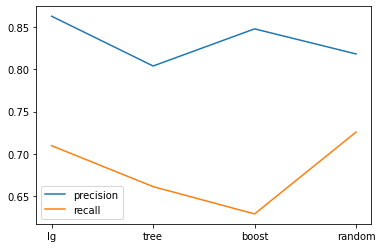

In [42]:
plt.plot(['lg', 'tree', 'boost', 'random'], precision_list, label='precision')
plt.plot(['lg', 'tree', 'boost', 'random'], recall_list, label='recall')
plt.legend()
plt.show()
# 사망, 진료 등은 racall / 추천 알고리즘은 precision
